In [18]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import yfinance as yf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [19]:
# Specify the initial value for generating random numbers to ensure consistent results
np.random.seed()

In [20]:
# Retrieving AAL stock data from Yahoo Finance
dataset = yf.download('AAL', start='2023-01-01', end='2023-12-31')
dataset.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,12.91,13.00,12.53,12.74,12.74,21865100
2023-01-04,12.86,13.61,12.86,13.59,13.59,34359100
2023-01-05,13.50,14.01,13.42,13.99,13.99,27378000
2023-01-06,14.01,14.25,13.92,14.18,14.18,29546400
2023-01-09,14.25,14.79,14.23,14.61,14.61,31496900


In [21]:
dataset.shape

(238, 6)

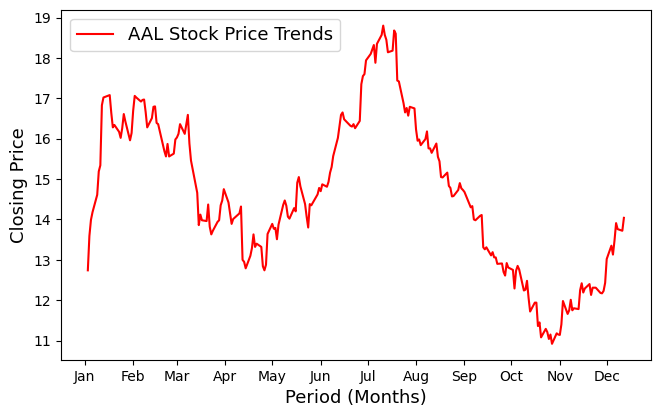

In [23]:
# Generating a visual representation of the final pricing of stocks
fig = plt.figure(figsize=(35, 10))
ax = fig.add_subplot(2, 4, 1)
ax.plot(dataset.index, dataset['Close'].values, label='AAL Stock Price Trends', color='red')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xlabel('Period (Months)', fontsize=13)
plt.ylabel('Closing Price', fontsize=13)
plt.legend(fontsize=13)
plt.show()

In [24]:
# Saving the dataset for the purpose of selecting features.
# Choosing the 'Close' pricing for subsequent research.
stock_dataset = dataset
stock_dataset.head()
data1 = stock_dataset[['Close']]
data1.head()

,Close
Date,
2023-01-03,12.74
2023-01-04,13.59
2023-01-05,13.99
2023-01-06,14.18
2023-01-09,14.61


In [25]:
print('The shape of the predicting dataset is ', stock_dataset.shape)

The shape of the predicting dataset is  (238, 6)


In [26]:
# Normalization function
def normaliser(data,frange =(0,1)):
    scaler = MinMaxScaler(feature_range=frange)
    dt = data.values
    scaled = scaler.fit_transform(dt)
    return scaled, scaler

In [27]:
# Normalizing the dataset
scaler1 = MinMaxScaler(feature_range = (0,1))
scaler2 = MinMaxScaler(feature_range = (0,1))
normalised_prices = scaler1.fit_transform(stock_dataset.values)
normalised_prices[0:5]
n = scaler2.fit_transform(data1)

In [28]:
# Function to prepare data for RNN
def rnn_data_setup(data, lookback, delay, min_index, max_index):
    n_samples=(max_index+1)-min_index-(lookback-1)-delay
    samples = np.zeros((n_samples,lookback,data.shape[-1]))
    targets = np.zeros((n_samples,delay))
    samp, targ = [], []
    for i in range(n_samples):
        indices1 = range(i, i+lookback)
        indices2 = range(i + lookback, i + lookback + delay)
        samples[i] = data[indices1]
        targets[i,:] = data[indices2][0:delay][:,0]
    samp.append(samples);targ.append(targets)
    return np.array(samp)[0],np.array(targ)[0]

In [29]:
# Setting parameters for the RNN input
lookback = 5
delay = 1
min_index = 0
max_index = len(normalised_prices) - lookback - delay

# Preparing the dataset
xdata, ydata = rnn_data_setup(normalised_prices, lookback, delay, min_index, max_index)
print('The shape of the input sample set is: ', xdata.shape)
print('The shape of the target set is: ', ydata.shape)

The shape of the input sample set is:  (228, 5, 6)
The shape of the target set is:  (228, 1)


In [30]:
# Splitting the dataset
train_size = int(len(xdata)*0.6)
valid_size = int(len(xdata)*0.2)
test_size = len(xdata) - train_size-valid_size

#Splitting the dataset into trainig, validation and testing.
xtrain, xvalid, xtest = xdata[0:train_size,:], xdata[train_size:train_size+valid_size,:], xdata[train_size+valid_size:len(xdata),:]
ytrain, yvalid, ytest = ydata[0:train_size,:], ydata[train_size:train_size+valid_size,:], ydata[train_size+valid_size:len(ydata),:]

print('The shape of the training sample is: ', xtrain.shape)
print('The shape of the validation sample is: ', xvalid.shape)
print('The shape of the testing sample is: ', xtest.shape)
print('The shape of the training target is: ', ytrain.shape)
print('The shape of the validation target is: ', yvalid.shape)
print('The shape of the testing target is: ', ytest.shape)

The shape of the training sample is:  (136, 5, 6)
The shape of the validation sample is:  (45, 5, 6)
The shape of the testing sample is:  (47, 5, 6)
The shape of the training target is:  (136, 1)
The shape of the validation target is:  (45, 1)
The shape of the testing target is:  (47, 1)


In [31]:
# Reshaping data for the RNN model
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], -1))
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], -1))

In [32]:
# Input variables
n_features = 8
lr = 0.0012 #Learning rate
units = 16 #Number hidden units
batch_size=512

In [33]:
# Building the RNN model
model1 = Sequential()
model1.add(SimpleRNN(units, activation='linear', input_shape=(5, 6)))  # Adjusted to (5, 6)
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [34]:
# Training the model
np.random.seed(1)
result1 = model1.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=100, verbose=0)

In [35]:
# Plotting training and validation loss
df = pd.DataFrame(result1.history)
df.tail()

,loss,mae,val_loss,val_mae
95,0.001846,0.035211,0.001179,0.026181
96,0.002061,0.037131,0.001433,0.030640
97,0.002311,0.038495,0.001348,0.027745
98,0.002265,0.039156,0.001631,0.033211
99,0.002164,0.037814,0.001193,0.026231


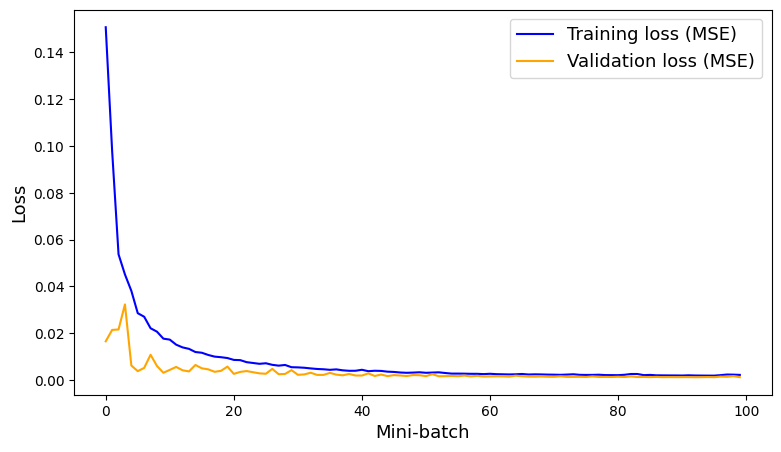

In [36]:
# Plotting training and validation loss
print('')
plt.figure(figsize=(9,5))
plt.plot(df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('RNN_error1.eps', format='eps', dpi=1000)
plt.show()

In [37]:
# Making predictions
preds1 = model1.predict(xtest)
preds1.shape

2/2 [==============================] - 0s 7ms/step


(47, 1)

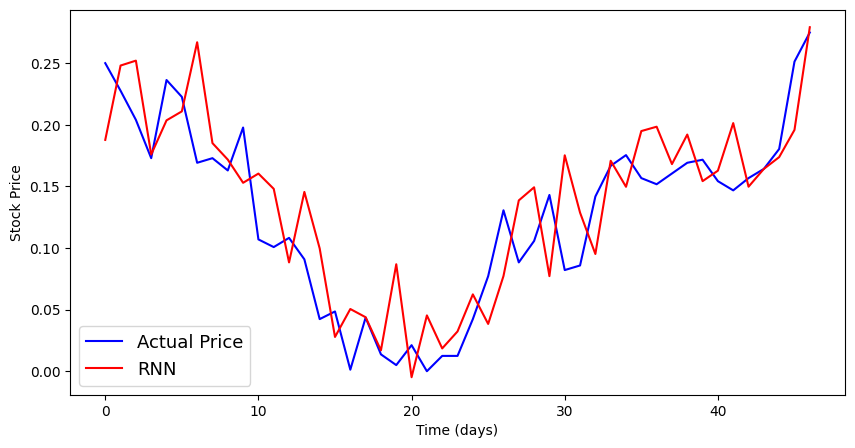

In [38]:
# Plotting predicted vs actual prices
print('')
plt.figure(figsize=(10,5))
plt.plot(ytest, label="Actual Price", color = 'blue')
plt.plot(preds1, label="RNN", color = 'red')
plt.xlabel('Time (days)')
plt.ylabel('Stock Price')
plt.legend(fontsize=13)
plt.show()

In [39]:
# Inverse transforming the predictions for comparison
real_pred1 = scaler2.inverse_transform(preds1)
ytest=ytest.reshape(-1, 1)
actuals = scaler2.inverse_transform(ytest)

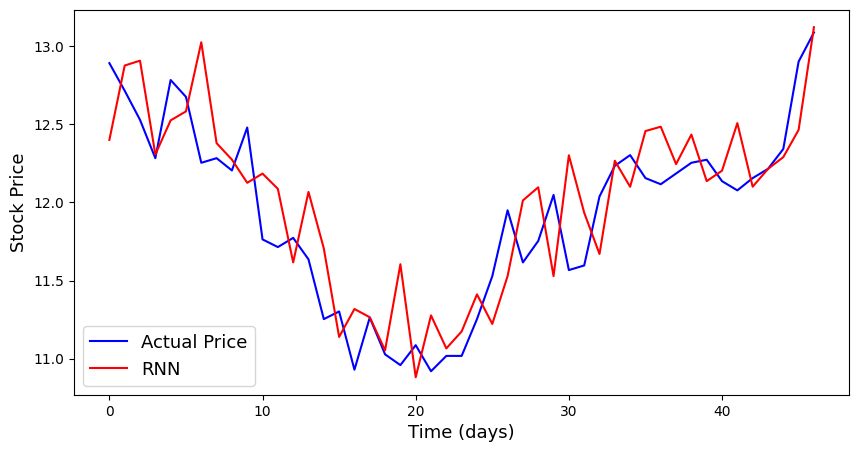

In [40]:
# Plotting actual vs predicted prices
print('')
plt.figure(figsize=(10,5))
plt.plot(actuals, label="Actual Price", color = 'blue')
plt.plot(real_pred1, label="RNN", color = 'red')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Stock Price', fontsize=13)
plt.legend(fontsize=13)
plt.savefig('RNN_model1.eps', format='eps', dpi=1000)
plt.show()

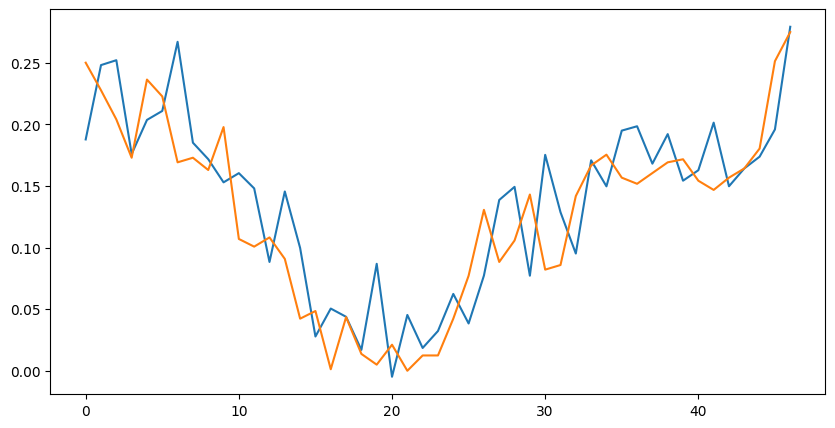

In [41]:
plt.figure(figsize=(10,5))
plt.plot(preds1[:300,:])
plt.plot(ytest[:300,:])
plt.show()

In [42]:
# Calculating error metrics
mse = mean_squared_error(actuals, real_pred1)
rmse = np.sqrt(mse)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

Mean Squared Error: 0.10800431930895556
Root Mean Squared Error: 0.32864010605669475


In [43]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_pred)) * 100

In [44]:
# Calculating absolute error and percentade error
mape = mean_absolute_percentage_error(actuals, real_pred1)
mae = mean_absolute_error(actuals, real_pred1)
print('Mean Absolute Percentage Error:', mape)
print('Mean Absolute Error:', mae)

Mean Absolute Percentage Error: 2.2031753171921817
Mean Absolute Error: 0.26501210093450667
